#### Multi output Model using the Keras Functional API

The goal of this notebook is to train a model to predict two outputs using the [Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) from **UCI** which had separate datasets for *red wine* and *white wine*.

We will combine the two datasets to predict the **wine quality** and whether the wine is **red** or **white** solely from the attributes.

We will model wine quality estimations as a **regression** problem and wine type detection as a **binary classification** problem.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools 
import utils # contains unit tests.

#### Load the Dataset

In [2]:
URL_WHITE = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
URL_RED = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

white_df = pd.read_csv(URL_WHITE, sep=';')
white_df['is_red'] = 0
white_df = white_df.drop_duplicates(keep='first')

red_df = pd.read_csv(URL_RED, sep=';')
red_df['is_red'] = 1
red_df = red_df.drop_duplicates(keep='first')

# Concatenate the datasets
df = pd.concat([white_df, red_df], ignore_index=True)

# Shuffle dataset. Normaly we should shuffle the dataset bt we will want later to to test with
# deterministic data
# df = df.iloc[np.random.permutation(len(df))]

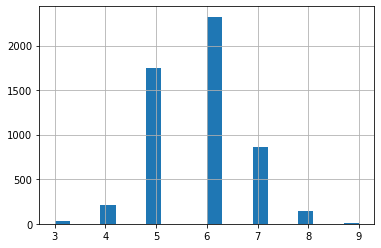

In [3]:
df['quality'].hist(bins=20)

#### Imbalanced

In [4]:
df = df[(df['quality'] > 4) & (df['quality'] < 8)]
df = df.reset_index(drop=True)

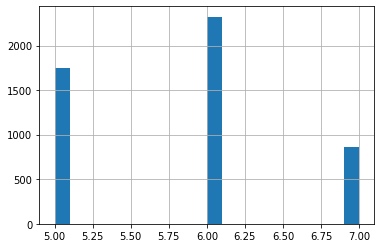

In [5]:
df['quality'].hist(bins=20)

#### Train Test split

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.2, random_state=1)

train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.218558,1.298609,3.80000,6.4000,7.0000,7.7000,15.60000
volatile acidity,3155.0,0.339976,0.164326,0.08000,0.2300,0.2900,0.4100,1.33000
citric acid,3155.0,0.321062,0.148083,0.00000,0.2500,0.3100,0.4000,1.66000
residual sugar,3155.0,5.128241,4.570110,0.60000,1.8000,2.8000,7.7000,65.80000
chlorides,3155.0,0.056971,0.037610,0.01400,0.0380,0.0470,0.0670,0.61100
free sulfur dioxide,3155.0,30.413946,17.179817,1.00000,17.0000,29.0000,41.0000,128.00000
total sulfur dioxide,3155.0,114.707132,56.189167,6.00000,75.0000,117.0000,153.0000,344.00000
density,3155.0,0.994580,0.002988,0.98722,0.9922,0.9948,0.9968,1.03898
pH,3155.0,3.221300,0.158116,2.72000,3.1100,3.2100,3.3200,3.90000
sulphates,3155.0,0.536662,0.150296,0.22000,0.4400,0.5100,0.6000,1.98000


In [7]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [8]:
train_Y = format_output(train)
val_Y = format_output(val)
test_Y = format_output(test)
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.2,0.19,0.46,3.8,0.041,82.0,187.0,0.99320,3.19,0.60,11.2
3557,6.9,0.25,0.29,2.4,0.038,28.0,76.0,0.99088,3.01,0.36,11.7
3825,11.0,0.30,0.58,2.1,0.054,7.0,19.0,0.99800,3.31,0.88,10.5
1740,7.0,0.36,0.30,5.0,0.040,40.0,143.0,0.99173,3.33,0.42,12.2
1221,5.8,0.19,0.49,4.9,0.040,44.0,118.0,0.99350,3.34,0.38,9.5


In [9]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [10]:
norm_train_X = norm(train)
norm_val_X = norm(val)
norm_test_X = norm(test)

#### Let's define the base model

In [11]:
def base_model(inputs):
    x = Dense(units='128', activation='relu')(inputs)
    x = Dense(units='128', activation='relu')(x)
    return x

#### Let's define output layers of the model

In [12]:
def final_model(inputs):
    x = base_model(inputs)
    
    wine_quality = Dense(units='1', name='wine_quality')(x)
    
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)
    
    model = Model(inputs=[inputs], outputs=[wine_quality, wine_type])
    return model

In [13]:
# METRICS = [
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'),
#     tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#     tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.Recall(name='recall'),
#     tf.keras.metrics.AUC(name='auc'),
# ]

#### Compiling the Model

In [14]:
inputs = Input(shape=(len(norm_train_X.columns),))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms,
             loss = {'wine_type' : 'binary_crossentropy',
                   'wine_quality' : 'mean_squared_error'
                  },
              
             metrics = {'wine_type' : 'accuracy', #METRICS
                      'wine_quality' : tf.keras.metrics.RootMeanSquaredError()
                     }
             )

In [15]:
history = model.fit(norm_train_X, train_Y,
                   epochs=180, validation_data=(norm_val_X, val_Y))

Epoch 1/180
99/99 [==============================] - 2s 8ms/step - loss: 31.8550 - wine_quality_loss: 31.1308 - wine_type_loss: 0.7241 - wine_quality_root_mean_squared_error: 5.5731 - wine_type_accuracy: 0.3976 - val_loss: 19.8908 - val_wine_quality_loss: 19.2006 - val_wine_type_loss: 0.6902 - val_wine_quality_root_mean_squared_error: 4.3819 - val_wine_type_accuracy: 0.5564
Epoch 2/180
99/99 [==============================] - 0s 2ms/step - loss: 16.8016 - wine_quality_loss: 16.1265 - wine_type_loss: 0.6751 - wine_quality_root_mean_squared_error: 4.0087 - wine_type_accuracy: 0.6128 - val_loss: 8.4073 - val_wine_quality_loss: 7.7669 - val_wine_type_loss: 0.6404 - val_wine_quality_root_mean_squared_error: 2.7869 - val_wine_type_accuracy: 0.6984
Epoch 3/180
99/99 [==============================] - 0s 2ms/step - loss: 6.9630 - wine_quality_loss: 6.3487 - wine_type_loss: 0.6143 - wine_quality_root_mean_squared_error: 2.5122 - wine_type_accuracy: 0.7645 - val_loss: 3.3560 - val_wine_quality_l

Epoch 23/180
99/99 [==============================] - 0s 2ms/step - loss: 0.6530 - wine_quality_loss: 0.6069 - wine_type_loss: 0.0460 - wine_quality_root_mean_squared_error: 0.7785 - wine_type_accuracy: 0.9943 - val_loss: 0.6186 - val_wine_quality_loss: 0.5654 - val_wine_type_loss: 0.0532 - val_wine_quality_root_mean_squared_error: 0.7519 - val_wine_type_accuracy: 0.9924
Epoch 24/180
99/99 [==============================] - 0s 2ms/step - loss: 0.5855 - wine_quality_loss: 0.5493 - wine_type_loss: 0.0362 - wine_quality_root_mean_squared_error: 0.7410 - wine_type_accuracy: 0.9956 - val_loss: 0.5957 - val_wine_quality_loss: 0.5436 - val_wine_type_loss: 0.0521 - val_wine_quality_root_mean_squared_error: 0.7373 - val_wine_type_accuracy: 0.9924
Epoch 25/180
99/99 [==============================] - 0s 2ms/step - loss: 0.5604 - wine_quality_loss: 0.5157 - wine_type_loss: 0.0447 - wine_quality_root_mean_squared_error: 0.7179 - wine_type_accuracy: 0.9934 - val_loss: 0.5733 - val_wine_quality_loss

Epoch 45/180
99/99 [==============================] - 0s 3ms/step - loss: 0.3347 - wine_quality_loss: 0.3140 - wine_type_loss: 0.0208 - wine_quality_root_mean_squared_error: 0.5602 - wine_type_accuracy: 0.9952 - val_loss: 0.4052 - val_wine_quality_loss: 0.3605 - val_wine_type_loss: 0.0447 - val_wine_quality_root_mean_squared_error: 0.6004 - val_wine_type_accuracy: 0.9937
Epoch 46/180
99/99 [==============================] - 0s 2ms/step - loss: 0.3562 - wine_quality_loss: 0.3181 - wine_type_loss: 0.0381 - wine_quality_root_mean_squared_error: 0.5639 - wine_type_accuracy: 0.9946 - val_loss: 0.4109 - val_wine_quality_loss: 0.3664 - val_wine_type_loss: 0.0445 - val_wine_quality_root_mean_squared_error: 0.6053 - val_wine_type_accuracy: 0.9937
Epoch 47/180
99/99 [==============================] - 0s 3ms/step - loss: 0.3306 - wine_quality_loss: 0.3042 - wine_type_loss: 0.0264 - wine_quality_root_mean_squared_error: 0.5514 - wine_type_accuracy: 0.9951 - val_loss: 0.4067 - val_wine_quality_loss

Epoch 67/180
99/99 [==============================] - 0s 2ms/step - loss: 0.3134 - wine_quality_loss: 0.2886 - wine_type_loss: 0.0248 - wine_quality_root_mean_squared_error: 0.5372 - wine_type_accuracy: 0.9959 - val_loss: 0.3855 - val_wine_quality_loss: 0.3436 - val_wine_type_loss: 0.0418 - val_wine_quality_root_mean_squared_error: 0.5862 - val_wine_type_accuracy: 0.9937
Epoch 68/180
99/99 [==============================] - 0s 2ms/step - loss: 0.3192 - wine_quality_loss: 0.2803 - wine_type_loss: 0.0389 - wine_quality_root_mean_squared_error: 0.5293 - wine_type_accuracy: 0.9934 - val_loss: 0.3911 - val_wine_quality_loss: 0.3493 - val_wine_type_loss: 0.0418 - val_wine_quality_root_mean_squared_error: 0.5910 - val_wine_type_accuracy: 0.9937
Epoch 69/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2989 - wine_quality_loss: 0.2821 - wine_type_loss: 0.0168 - wine_quality_root_mean_squared_error: 0.5310 - wine_type_accuracy: 0.9964 - val_loss: 0.3897 - val_wine_quality_loss

Epoch 89/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2994 - wine_quality_loss: 0.2771 - wine_type_loss: 0.0223 - wine_quality_root_mean_squared_error: 0.5263 - wine_type_accuracy: 0.9945 - val_loss: 0.3792 - val_wine_quality_loss: 0.3397 - val_wine_type_loss: 0.0395 - val_wine_quality_root_mean_squared_error: 0.5828 - val_wine_type_accuracy: 0.9937
Epoch 90/180
99/99 [==============================] - 0s 3ms/step - loss: 0.2936 - wine_quality_loss: 0.2752 - wine_type_loss: 0.0184 - wine_quality_root_mean_squared_error: 0.5245 - wine_type_accuracy: 0.9956 - val_loss: 0.3804 - val_wine_quality_loss: 0.3409 - val_wine_type_loss: 0.0395 - val_wine_quality_root_mean_squared_error: 0.5839 - val_wine_type_accuracy: 0.9937
Epoch 91/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2875 - wine_quality_loss: 0.2702 - wine_type_loss: 0.0173 - wine_quality_root_mean_squared_error: 0.5197 - wine_type_accuracy: 0.9967 - val_loss: 0.3822 - val_wine_quality_loss

Epoch 111/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2853 - wine_quality_loss: 0.2633 - wine_type_loss: 0.0220 - wine_quality_root_mean_squared_error: 0.5131 - wine_type_accuracy: 0.9961 - val_loss: 0.3831 - val_wine_quality_loss: 0.3451 - val_wine_type_loss: 0.0380 - val_wine_quality_root_mean_squared_error: 0.5875 - val_wine_type_accuracy: 0.9937
Epoch 112/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2819 - wine_quality_loss: 0.2634 - wine_type_loss: 0.0186 - wine_quality_root_mean_squared_error: 0.5132 - wine_type_accuracy: 0.9965 - val_loss: 0.3832 - val_wine_quality_loss: 0.3454 - val_wine_type_loss: 0.0378 - val_wine_quality_root_mean_squared_error: 0.5877 - val_wine_type_accuracy: 0.9937
Epoch 113/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2890 - wine_quality_loss: 0.2672 - wine_type_loss: 0.0219 - wine_quality_root_mean_squared_error: 0.5166 - wine_type_accuracy: 0.9949 - val_loss: 0.3787 - val_wine_quality_l

Epoch 133/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2667 - wine_quality_loss: 0.2531 - wine_type_loss: 0.0136 - wine_quality_root_mean_squared_error: 0.5031 - wine_type_accuracy: 0.9970 - val_loss: 0.3798 - val_wine_quality_loss: 0.3428 - val_wine_type_loss: 0.0370 - val_wine_quality_root_mean_squared_error: 0.5855 - val_wine_type_accuracy: 0.9949
Epoch 134/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2742 - wine_quality_loss: 0.2632 - wine_type_loss: 0.0110 - wine_quality_root_mean_squared_error: 0.5129 - wine_type_accuracy: 0.9967 - val_loss: 0.3756 - val_wine_quality_loss: 0.3386 - val_wine_type_loss: 0.0370 - val_wine_quality_root_mean_squared_error: 0.5819 - val_wine_type_accuracy: 0.9949
Epoch 135/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2645 - wine_quality_loss: 0.2499 - wine_type_loss: 0.0146 - wine_quality_root_mean_squared_error: 0.4998 - wine_type_accuracy: 0.9973 - val_loss: 0.3777 - val_wine_quality_l

Epoch 155/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2581 - wine_quality_loss: 0.2495 - wine_type_loss: 0.0086 - wine_quality_root_mean_squared_error: 0.4995 - wine_type_accuracy: 0.9979 - val_loss: 0.3760 - val_wine_quality_loss: 0.3398 - val_wine_type_loss: 0.0362 - val_wine_quality_root_mean_squared_error: 0.5829 - val_wine_type_accuracy: 0.9949
Epoch 156/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2571 - wine_quality_loss: 0.2468 - wine_type_loss: 0.0103 - wine_quality_root_mean_squared_error: 0.4967 - wine_type_accuracy: 0.9977 - val_loss: 0.3831 - val_wine_quality_loss: 0.3471 - val_wine_type_loss: 0.0360 - val_wine_quality_root_mean_squared_error: 0.5891 - val_wine_type_accuracy: 0.9949
Epoch 157/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2565 - wine_quality_loss: 0.2400 - wine_type_loss: 0.0165 - wine_quality_root_mean_squared_error: 0.4898 - wine_type_accuracy: 0.9967 - val_loss: 0.3761 - val_wine_quality_l

Epoch 177/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2522 - wine_quality_loss: 0.2434 - wine_type_loss: 0.0088 - wine_quality_root_mean_squared_error: 0.4933 - wine_type_accuracy: 0.9981 - val_loss: 0.3777 - val_wine_quality_loss: 0.3418 - val_wine_type_loss: 0.0358 - val_wine_quality_root_mean_squared_error: 0.5847 - val_wine_type_accuracy: 0.9949
Epoch 178/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2524 - wine_quality_loss: 0.2370 - wine_type_loss: 0.0154 - wine_quality_root_mean_squared_error: 0.4868 - wine_type_accuracy: 0.9963 - val_loss: 0.3759 - val_wine_quality_loss: 0.3401 - val_wine_type_loss: 0.0358 - val_wine_quality_root_mean_squared_error: 0.5832 - val_wine_type_accuracy: 0.9949
Epoch 179/180
99/99 [==============================] - 0s 2ms/step - loss: 0.2608 - wine_quality_loss: 0.2440 - wine_type_loss: 0.0168 - wine_quality_root_mean_squared_error: 0.4940 - wine_type_accuracy: 0.9960 - val_loss: 0.3810 - val_wine_quality_l

In [16]:
#Gather training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'Loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_quality_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 2ms/step - loss: 0.3759 - wine_quality_loss: 0.3401 - wine_type_loss: 0.0358 - wine_quality_root_mean_squared_error: 0.5832 - wine_type_accuracy: 0.9949

Loss: 0.3759327530860901
wine_quality_loss: 0.3400968909263611
wine_type_loss: 0.03583581745624542
wine_quality_rmse: 0.5831782817840576
wine_quality_accuracy: 0.9949302673339844


In [17]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [18]:
print(quality_pred[0])

[6.7409983]


In [19]:
print(type_pred[0])
print(type_pred[986])

[9.655935e-05]
[0.00122303]


#### Plot Utilities

In [20]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

In [21]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0, 1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_xticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [22]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

#### Plots for metrics

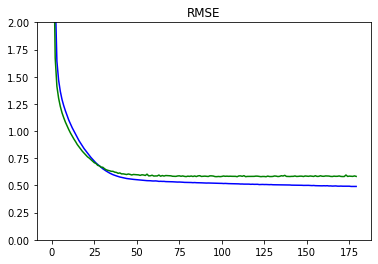

In [23]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

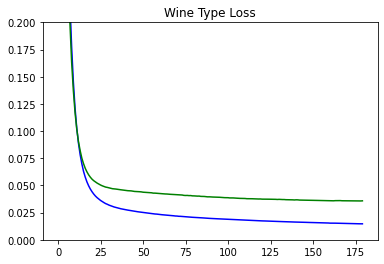

In [24]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

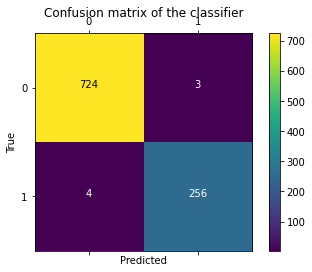

In [25]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

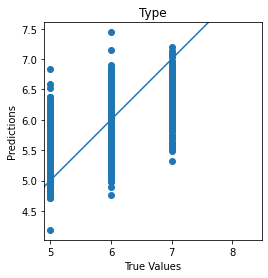

In [26]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')